## Hurricane Florence PyDDA retrieval

In [1]:
import warnings
warnings.filterwarnings("ignore")
import glob
import pyart
import pydda
import datetime
import cartopy.crs as ccrs
import os
import dask.bag as db
import gc

from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator
%pylab inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Populating the interactive namespace from numpy and matplotlib


In [13]:
florence_path = '/lcrc/group/earthscience/radar/florance/'
ltx_list = sorted(glob.glob(florence_path + '/**/KLTX*V06.ar2v', recursive=True))
mhx_list = sorted(glob.glob(florence_path + '/**/KMHX*V06.ar2v', recursive=True))
print(len(ltx_list))

880


In [14]:
print(mhx_list[0])

def parse_dt(file_path):
    return (datetime.datetime.strptime(file_path[-24:-9], '%Y%m%d_%H%M%S'))

mhx_times = np.array([parse_dt(x) for x in ltx_list])
ltx_times = np.array([parse_dt(x) for x in mhx_list])

/lcrc/group/earthscience/radar/florance/2018/09/13/KMHX20180913_000106_V06.ar2v


In [5]:
the_time = datetime.datetime(2018,9,14,6,50)
the_ind_mhx = np.argmin(np.abs(mhx_times-the_time))
the_ind_ltx = np.argmin(np.abs(ltx_times-the_time))
mhx_radar = pyart.io.read(ltx_list[the_ind_mhx])
ltx_radar = pyart.io.read(mhx_list[the_ind_ltx])
gf_mhx = pyart.filters.GateFilter(mhx_radar)
gf_mhx.exclude_below('cross_correlation_ratio', 0.5)
gf_mhx.exclude_below('reflectivity', -20)
gf_ltx = pyart.filters.GateFilter(ltx_radar)
gf_ltx.exclude_below('cross_correlation_ratio', 0.5)
gf_ltx.exclude_below('reflectivity', -20)

In [ ]:
display_mhgx = pyart.graph.RadarMapDisplay(mhx_radar)
display_mhgx.plot_ppi_map('reflectivity', resolution='l', gatefilter=gf_mhx)

In [ ]:
display_ltx = pyart.graph.RadarMapDisplay(ltx_radar)
display_ltx.plot_ppi_map('reflectivity', resolution='l', gatefilter=gf_ltx)

In [ ]:
plt.figure(figsize=(9,9))
display_mhgx.plot_ppi_map('velocity', sweep=1, resolution='l')

In [ ]:
plt.figure(figsize=(9,9))
display_ltx = pyart.graph.RadarMapDisplay(ltx_radar)
display_ltx.plot_ppi_map('velocity', sweep=1, resolution='l')

In [ ]:
plt.figure(figsize=(9,9))
dealiased_vel_mhx = pyart.correct.dealias_region_based(mhx_radar)
mhx_radar.add_field('corrected_velocity', dealiased_vel_mhx, replace_existing=True)
display_mhgx.plot_ppi_map('corrected_velocity', sweep=1, resolution='l')

In [ ]:
plt.figure(figsize=(9,9))
dealiased_vel_ltx = pyart.correct.dealias_region_based(ltx_radar)
ltx_radar.add_field('corrected_velocity', dealiased_vel_ltx, replace_existing=True)
display_ltx.plot_ppi_map('corrected_velocity', sweep=1, resolution='l', vmin=-100, vmax=100)

In [ ]:
mhx_radar.fields.keys()

In [ ]:
grid_mhx = pyart.map.grid_from_radars(mhx_radar,(31,351,401),
                   ((0.,15000.),(-100000.,200000.),(-150000.,300000.)),
                   fields=['reflectivity','corrected_velocity'],
                   refl_field='reflectivity',roi_func='dist_beam',
                   h_factor=0.,nb=0.6,bsp=1.,min_radius=200.,
                   grid_origin=(mhx_radar.latitude['data'], mhx_radar.longitude['data'])
                   )

grid_ltx = pyart.map.grid_from_radars(ltx_radar,(31,351,401),
                   ((0.,15000.),(-100000.,200000.),(-150000.,300000.)),
                   fields=['reflectivity','corrected_velocity'],
                   refl_field='reflectivity',roi_func='dist_beam',
                   h_factor=0,nb=0.6,bsp=1.,min_radius=200.,
                   grid_origin=(mhx_radar.latitude['data'], mhx_radar.longitude['data'])
                   )

pyart.io.write_grid('grid_mhx.nc', grid_mhx)
pyart.io.write_grid('grid_ltx.nc', grid_ltx)

In [2]:
grid_mhx = pyart.io.read_grid('grid_mhx.nc')
grid_ltx = pyart.io.read_grid('grid_ltx.nc')

In [ ]:
plt.figure(figsize=(10,4))
grid_disp_mhx = pyart.graph.GridMapDisplay(grid_mhx)
grid_disp_mhx.plot_longitude_slice('corrected_velocity', lat=-78)

In [ ]:
grid_disp_mhx.plot_grid('corrected_velocity', level=5)

In [3]:
u_init, v_init, w_init = pydda.initialization.make_constant_wind_field(grid_mhx, (0.0, 0.0, 0.0))
out_grids = pydda.retrieval.get_dd_wind_field([grid_mhx, grid_ltx], u_init, v_init, w_init, Co=1.0, Cm=100.0,
                                             mask_outside_opt=True, vel_name='corrected_velocity')

Calculating weights for radars 0 and 1
Calculating weights for models...
Starting solver 
rmsVR = 431.0271690123924
Total points:2043251.0
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Max w  
| 548.3685|  81.6108|   0.0000|   0.0000|   0.0000|   0.0000|  22.6079
Norm of gradient: 0.000994309865064257
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Max w  
| 548.3685|  81.6108|   0.0000|   0.0000|   0.0000|   0.0000|  22.6079
Norm of gradient: 0.000994309865064257
Iterations before filter: 20
Applying low pass filter to wind field...
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Max w  
| 768.7337|  54.6971|   0.0000|   0.0000|   0.0000|   0.0000|   8.4213
Norm of gradient: 0.0012261662301069984
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Max w  
| 768.7210|  54.6915|   0.0000|   0.0000|   0.0000|   0.0000|   8.4210
Norm of gradient: 0.001225773004661221
| Jvel    | Jmass   | Jsmooth |   Jbg   

In [ ]:
pyart.io.write_grid('grid0.nc', out_grids[0])
pyart.io.write_grid('grid1.nc', out_grids[1])

In [ ]:
out_grids[0].projection_proj

In [ ]:
out_grids = [pyart.io.read_grid('grid0.nc'),
             pyart.io.read_grid('grid1.nc')]

In [ ]:
fig = plt.figure(figsize=(15,10)) 
ax = plt.axes(projection=ccrs.PlateCarree())
out_grids[1].fields['u']['data'] = np.ma.masked_where(np.logical_or(out_grids[0].fields['corrected_velocity']['data'].mask,
                                                                    out_grids[1].fields['corrected_velocity']['data'].mask),
                                                      out_grids[1].fields['u']['data'])
out_grids[1].fields['v']['data'] = np.ma.masked_where(np.logical_or(out_grids[0].fields['corrected_velocity']['data'].mask,
                                                                    out_grids[1].fields['corrected_velocity']['data'].mask),
                                                      out_grids[1].fields['v']['data'])
ax = pydda.vis.plot_horiz_xsection_barbs_map(out_grids, ax=ax, bg_grid_no=-1, level=3, barb_spacing_x_km=20.0,
                                             barb_spacing_y_km=20.0)

plt.title(out_grids[0].time['units'][13:] + ' winds at 1.5 km')

In [ ]:
grid_array = np.ma.stack([x.fields['reflectivity']['data'] for x in out_grids])
plt.imshow(grid_array.max(axis=0)[3])

### Load historical HRRR data

In [ ]:
import cfgrib

In [ ]:
hrrr_data_path = '/lcrc/group/earthscience/rjackson/florence_hrrr/20180914/hrrr.t06z.wrfprsf00.grib2'
the_grib = cfgrib.Dataset.from_path(hrrr_data_path, filter_by_keys={'typeOfLevel': 'isobaricInhPa'})

In [ ]:
the_grib.variables.keys()

In [ ]:
grb_u = the_grib.variables['u']
grb_v = the_grib.variables['v']
gh = the_grib.variables['gh']

lat = the_grib.variables['latitude'].data[:,:]
lon = the_grib.variables['longitude'].data[:,:]
lon[lon > 180] = lon[lon>180]-360
print(lon.shape)

In [ ]:
EARTH_MEAN_RADIUS = 6.3781e6
gh = gh.data[:,:,:]
height = (EARTH_MEAN_RADIUS*gh)/(EARTH_MEAN_RADIUS-gh)

In [ ]:
the_grib.variables.keys()

In [ ]:
from scipy.interpolate import griddata
ax = plt.axes(projection=ccrs.PlateCarree())
u = grb_u.data[1,:,:]
# need to shift data grid longitudes from (0..360) to (-180..180)
v = grb_v.data[0,:,:]
# need to shift data grid longitudes from (0..360) to (-180..180)

r = the_grib.variables['gh']
u = u[:,:]
p = ax.pcolormesh(lon, lat, u, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.set_xlim([-80, -75])
ax.set_ylim([33, 36])
plt.colorbar(p)

## Grid the HRRR data onto the analysis grid

In [ ]:
# We do not need the entire box, just the radar domain
radar_grid_lat = out_grids[0].point_latitude['data']
radar_grid_lon = out_grids[0].point_longitude['data']
radar_grid_alt = out_grids[0].point_z['data']
lat_min = radar_grid_lat.min()
lat_max = radar_grid_lat.max()
lon_min = radar_grid_lon.min()
lon_max = radar_grid_lon.max()
lon_r = np.tile(lon, (height.shape[0],1,1))
lat_r = np.tile(lat, (height.shape[0],1,1))
lon_flattened = lon_r.flatten()
lat_flattened = lat_r.flatten()
height_flattened = gh.flatten()
the_box = np.where(np.logical_and.reduce((lon_flattened >= lon_min, lat_flattened >= lat_min,
                                          lon_flattened <= lon_max, lat_flattened <= lat_max)))[0]

lon_flattened = lon_flattened[the_box]
lat_flattened = lat_flattened[the_box]
height_flattened = height_flattened[the_box]

u_flattened = grb_u.data[:,:,:].flatten()
u_flattened = u_flattened[the_box]
u_interp = NearestNDInterpolator((height_flattened, lat_flattened, lon_flattened), u_flattened, rescale=True)
u_new = u_interp(radar_grid_alt, radar_grid_lat, radar_grid_lon)

In [ ]:
print(u_new.shape)
u_dict = {'data': u_new, 'long_name': "U from HRRR", 'units': "m/s"}
out_grids[0].add_field("U_hrrr", u_dict, replace_existing=True)

In [ ]:
disp = pyart.graph.GridMapDisplay(out_grids[0])
disp.plot_grid('U_hrrr', level=2)

In [ ]:
plt.pcolormesh(u_new[2])

In [ ]:
np.where(np.logical_and.reduce((lon_r.flatten() >= lon_min,
                                          lon_r.flatten() <= lon_max)))[0]


In [ ]:
print(lon_max)

In [ ]:
out_grids

## Now do the retrieval with HRRR data, dude!

/home/rjackson/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1303: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/home/rjackson/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1303: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/home/rjackson/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1303: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/home/rjackson/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1303: DeprecationWarning: The binary mode of fromstring is 

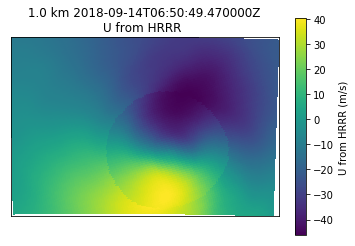

In [2]:
grid_mhx = pyart.io.read_grid('grid_mhx.nc')
grid_ltx = pyart.io.read_grid('grid_ltx.nc')
grid_mhx = pydda.initialization.add_hrrr_constraint_to_grid(grid_mhx,
    '/lcrc/group/earthscience/rjackson/florence_hrrr/20180914/hrrr.t06z.wrfprsf00.grib2')
disp = pyart.graph.GridMapDisplay(grid_mhx)
disp.plot_grid('U_hrrr', level=2)

In [3]:
u_init, v_init, w_init = pydda.initialization.make_constant_wind_field(grid_mhx, (0.0, 0.0, 0.0))
out_grids = pydda.retrieval.get_dd_wind_field([grid_mhx, grid_ltx], u_init, v_init, w_init, Co=10.0, Cm=50.0,
                                              Cmod=0.0, mask_outside_opt=True, vel_name='corrected_velocity',
                                               
                                              )

Calculating weights for radars 0 and 1
Calculating weights for models...
Starting solver 
rmsVR = 431.0271690123924
Total points:2043251.0


KeyboardInterrupt: 

Text(0.5,1,' 2018-09-14T06:50:49Z winds at 0.5 km')

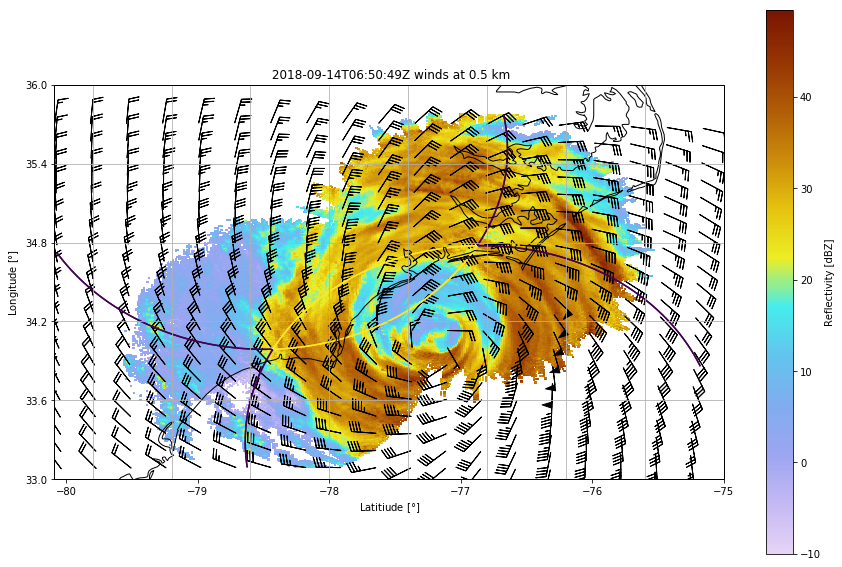

In [13]:
fig = plt.figure(figsize=(15,10)) 
ax = plt.axes(projection=ccrs.PlateCarree())
#out_grids[1].fields['u']['data'] = np.ma.masked_where(np.logical_or(out_grids[0].fields['corrected_velocity']['data'].mask,
#                                                                    out_grids[1].fields['corrected_velocity']['data'].mask),
#                                                      out_grids[1].fields['u']['data'])
#out_grids[1].fields['v']['data'] = np.ma.masked_where(np.logical_or(out_grids[0].fields['corrected_velocity']['data'].mask,
#                                                                    out_grids[1].fields['corrected_velocity']['data'].mask),
#                                                      out_grids[1].fields['v']['data'])
ax = pydda.vis.plot_horiz_xsection_barbs_map(out_grids, ax=ax, bg_grid_no=-1, level=1, barb_spacing_x_km=20.0,
                                             barb_spacing_y_km=20.0)

plt.title(out_grids[0].time['units'][13:] + ' winds at 0.5 km')

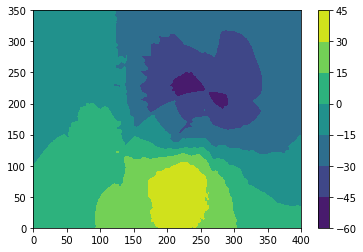

In [48]:
max_w = out_grids[1].fields['u']['data'][2]
plt.contourf(max_w)
plt.colorbar()

## Hey there, it's time for Dask-jobqueue!

In [2]:
import dask_jobqueue
import dask.bag as db

/home/rjackson/anaconda3/lib/python3.6/site-packages/docrep-0.2.3-py3.6.egg/docrep/__init__.py:24: DeprecationWarning: Flags not at the start of the expression '(?<!%)(%%)*%(?!%)   ' (truncated)
  \((?P<key>(?s).*?)\)# key enclosed in brackets""", re.VERBOSE)


In [164]:
out_img_path = '/lcrc/group/earthscience/rjackson/florence_winds/png/'
out_grid_path = '/lcrc/group/earthscience/rjackson/florence_winds/grids/'

def make_retrieved_grid(the_time, ltx_list, mhx_list, do_hrrr=True):
    out_grid_dir = (out_grid_path + '/' + "%04d" % the_time.year +
                   "%02d" % the_time.month +"%02d" % the_time.day + '/')
    out_img_dir = (out_img_path + '/' + "%04d" % the_time.year +
                   "%02d" % the_time.month +"%02d" % the_time.day + '/')
    if(not os.path.isdir((out_img_dir))):
        os.makedirs(out_img_dir)
    if(not os.path.isdir((out_grid_dir))):
        os.makedirs(out_grid_dir)
    if(do_hrrr == True):
        out_grid_mhx_file_path = (out_grid_dir + '05kmwinds_gridmhx' + "%04d" % the_time.year + 
            "%02d" % the_time.month + "%02d" % the_time.day + '.' +
            "%02d" % the_time.hour + "%02d" % the_time.minute + '.nc') 
        out_grid_ltx_file_path = (out_grid_dir + '05kmwinds_gridltx' + "%04d" % the_time.year + 
            "%02d" % the_time.month + "%02d" % the_time.day + '.' +
            "%02d" % the_time.hour + "%02d" % the_time.minute + '.nc') 
        out_img_file_path = (out_img_dir + '05kmwinds' + "%04d" % the_time.year + 
                         "%02d" % the_time.month + "%02d" % the_time.day + '.' +
                         "%02d" % the_time.hour + "%02d" % the_time.minute + '.png')
    else:
        out_grid_mhx_file_path = (out_grid_dir + '05kmwinds_gridmhx' + "%04d" % the_time.year + 
            "%02d" % the_time.month + "%02d" % the_time.day + '.' +
            "%02d" % the_time.hour + "%02d" % the_time.minute + 'nohrrr.nc')
        out_grid_ltx_file_path = (out_grid_dir + '05kmwinds_gridltx' + "%04d" % the_time.year + 
            "%02d" % the_time.month + "%02d" % the_time.day + '.' +
            "%02d" % the_time.hour + "%02d" % the_time.minute + 'nohrrr.nc') 
        out_img_file_path = (out_img_dir + '05kmwinds' + "%04d" % the_time.year + 
                         "%02d" % the_time.month + "%02d" % the_time.day + '.' +
                         "%02d" % the_time.hour + "%02d" % the_time.minute + '.nohrr.png')
        
    if(os.path.isfile(out_grid_mhx_file_path) and os.path.isfile(out_grid_ltx_file_path)):
        return
    
    print("## Loading data...")
    the_ind_mhx = np.argmin(np.abs(mhx_times-the_time))
    the_ind_ltx = np.argmin(np.abs(ltx_times-the_time))
    if(np.abs(mhx_times[the_ind_mhx]-ltx_times[the_ind_ltx]) > datetime.timedelta(minutes=5)):
        print("No simultaneous coverage!")
        return
    try:
        mhx_radar = pyart.io.read(ltx_list[the_ind_mhx])
        ltx_radar = pyart.io.read(mhx_list[the_ind_ltx])
    except:
        print(str(the_time) + " Failed!")
        return
        
    gf_mhx = pyart.filters.GateFilter(mhx_radar)
    gf_mhx.exclude_below('cross_correlation_ratio', 0.5)
    gf_mhx.exclude_below('reflectivity', -20)
    gf_ltx = pyart.filters.GateFilter(ltx_radar)
    gf_ltx.exclude_below('cross_correlation_ratio', 0.5)
    gf_ltx.exclude_below('reflectivity', -20)

    print("## Dealiasing...")
    # Dealias
    try:
        dealiased_vel_mhx = pyart.correct.dealias_region_based(mhx_radar)
        mhx_radar.add_field('corrected_velocity', dealiased_vel_mhx, replace_existing=True) 
        dealiased_vel_ltx = pyart.correct.dealias_region_based(ltx_radar)
        ltx_radar.add_field('corrected_velocity', dealiased_vel_ltx, replace_existing=True)  
    except KeyError:
        print("No velocity information available!")
        return
    
    print("## Gridding...")
    # Grid
    grid_mhx = pyart.map.grid_from_radars(mhx_radar,(31,351,401),
                   ((0.,15000.),(-100000.,200000.),(-150000.,300000.)),
                   fields=['reflectivity','corrected_velocity'],
                   refl_field='reflectivity',roi_func='dist_beam',
                   h_factor=0.,nb=0.6,bsp=1.,min_radius=200.,
                   grid_origin=(mhx_radar.latitude['data'], mhx_radar.longitude['data'])
                   )

    grid_ltx = pyart.map.grid_from_radars(ltx_radar,(31,351,401),
                   ((0.,15000.),(-100000.,200000.),(-150000.,300000.)),
                   fields=['reflectivity','corrected_velocity'],
                   refl_field='reflectivity',roi_func='dist_beam',
                   h_factor=0,nb=0.6,bsp=1.,min_radius=200.,
                   grid_origin=(mhx_radar.latitude['data'], mhx_radar.longitude['data'])
                   )

    # Get HRRR data from nearest hour
    if(do_hrrr == True):
        print("## Processing HRRR data...")
        hrrr_date = datetime.datetime(the_time.year, the_time.month, the_time.day, the_time.hour)
        if(the_time.minute > 30):
            hrrr_date += datetime.timedelta(hours=1)
    
        hrrr_path = ('/lcrc/group/earthscience/rjackson/florence_hrrr/' + 
                     "%04d" % hrrr_date.year +
                     "%02d" % hrrr_date.month +
                     "%02d" % hrrr_date.day +
                     '/hrrr.t' + "%02d" % hrrr_date.hour  + 'z.wrfprsf00.grib2')
        grid_mhx = pydda.initialization.add_hrrr_constraint_to_grid(grid_mhx,
            hrrr_path)
        Cmod = 5e-6
        model_fields=["hrrr"]
    else:
        Cmod = 0.0
        model_fields=None
        
    print("## Running PyDDA...")
    u_init, v_init, w_init = pydda.initialization.make_constant_wind_field(grid_mhx, (0.0, 0.0, 0.0))
    out_grids = pydda.retrieval.get_dd_wind_field([grid_mhx, grid_ltx], u_init, v_init, w_init, Co=10.0, Cm=50.0,
                                              Cmod=Cmod, mask_outside_opt=True, vel_name='corrected_velocity',
                                              model_fields=model_fields
                                              )
    print('## Making plot..')
    fig = plt.figure(figsize=(15,10)) 
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax = pydda.vis.plot_horiz_xsection_barbs_map(out_grids, ax=ax, bg_grid_no=-1, level=1, barb_spacing_x_km=20.0,
                                             barb_spacing_y_km=20.0)

    plt.title(out_grids[0].time['units'][13:] + ' winds at 0.5 km')
    print("## Saving plot...")
       
    plt.savefig(out_img_file_path)
 
    pyart.io.write_grid(out_grid_mhx_file_path, out_grids[0])
    pyart.io.write_grid(out_grid_ltx_file_path, out_grids[1])
    del out_grids, grid_mhx, grid_ltx, mhx_radar, ltx_radar, u_init, v_init, w_init
    gc.collect()
    
    
def make_retrieved_grid_only_hrrr(the_time, ltx_list, mhx_list, do_hrrr=True):
    out_grid_dir = (out_grid_path + '/' + "%04d" % the_time.year +
                   "%02d" % the_time.month +"%02d" % the_time.day + '/')
    out_img_dir = (out_img_path + '/' + "%04d" % the_time.year +
                   "%02d" % the_time.month +"%02d" % the_time.day + '/')
    if(not os.path.isdir((out_img_dir))):
        os.makedirs(out_img_dir)
    if(not os.path.isdir((out_grid_dir))):
        os.makedirs(out_grid_dir)
    if(do_hrrr == True):
        out_grid_mhx_file_path = (out_grid_dir + '05kmwinds_gridmhx' + "%04d" % the_time.year + 
            "%02d" % the_time.month + "%02d" % the_time.day + '.' +
            "%02d" % the_time.hour + "%02d" % the_time.minute + '.onlyhrrr.nc') 
        out_grid_ltx_file_path = (out_grid_dir + '05kmwinds_gridltx' + "%04d" % the_time.year + 
            "%02d" % the_time.month + "%02d" % the_time.day + '.' +
            "%02d" % the_time.hour + "%02d" % the_time.minute + '.onlyhrrr.nc') 
        out_img_file_path = (out_img_dir + '05kmwinds' + "%04d" % the_time.year + 
                         "%02d" % the_time.month + "%02d" % the_time.day + '.' +
                         "%02d" % the_time.hour + "%02d" % the_time.minute + '.onlyhrrr.png')
    else:
        out_grid_mhx_file_path = (out_grid_dir + '05kmwinds_gridmhx' + "%04d" % the_time.year + 
            "%02d" % the_time.month + "%02d" % the_time.day + '.' +
            "%02d" % the_time.hour + "%02d" % the_time.minute + 'hrrronly.nc')
        out_grid_ltx_file_path = (out_grid_dir + '05kmwinds_gridltx' + "%04d" % the_time.year + 
            "%02d" % the_time.month + "%02d" % the_time.day + '.' +
            "%02d" % the_time.hour + "%02d" % the_time.minute + 'hrrronly.nc') 
        out_img_file_path = (out_img_dir + '05kmwinds' + "%04d" % the_time.year + 
                         "%02d" % the_time.month + "%02d" % the_time.day + '.' +
                         "%02d" % the_time.hour + "%02d" % the_time.minute + '.nohrr.png')
        
    if(os.path.isfile(out_grid_mhx_file_path) and os.path.isfile(out_grid_ltx_file_path)):
        return
    
    print("## Loading data...")
    the_ind_mhx = np.argmin(np.abs(mhx_times-the_time))
    the_ind_ltx = np.argmin(np.abs(ltx_times-the_time))
    if(np.abs(mhx_times[the_ind_mhx]-ltx_times[the_ind_ltx]) > datetime.timedelta(minutes=5)):
        print("No simultaneous coverage!")
        return
    try:
        mhx_radar = pyart.io.read(ltx_list[the_ind_mhx])
        ltx_radar = pyart.io.read(mhx_list[the_ind_ltx])
    except:
        print(str(the_time) + " Failed!")
        return
        
    gf_mhx = pyart.filters.GateFilter(mhx_radar)
    gf_mhx.exclude_below('cross_correlation_ratio', 0.5)
    gf_mhx.exclude_below('reflectivity', -20)
    gf_ltx = pyart.filters.GateFilter(ltx_radar)
    gf_ltx.exclude_below('cross_correlation_ratio', 0.5)
    gf_ltx.exclude_below('reflectivity', -20)

    print("## Dealiasing...")
    # Dealias
    try:
        dealiased_vel_mhx = pyart.correct.dealias_region_based(mhx_radar)
        mhx_radar.add_field('corrected_velocity', dealiased_vel_mhx, replace_existing=True) 
        dealiased_vel_ltx = pyart.correct.dealias_region_based(ltx_radar)
        ltx_radar.add_field('corrected_velocity', dealiased_vel_ltx, replace_existing=True)  
    except KeyError:
        print("No velocity information available!")
        return
    
    print("## Gridding...")
    # Grid
    grid_mhx = pyart.map.grid_from_radars(mhx_radar,(31,351,401),
                   ((0.,15000.),(-100000.,200000.),(-150000.,300000.)),
                   fields=['reflectivity','corrected_velocity'],
                   refl_field='reflectivity',roi_func='dist_beam',
                   h_factor=0.,nb=0.6,bsp=1.,min_radius=200.,
                   grid_origin=(mhx_radar.latitude['data'], mhx_radar.longitude['data'])
                   )

    grid_ltx = pyart.map.grid_from_radars(ltx_radar,(31,351,401),
                   ((0.,15000.),(-100000.,200000.),(-150000.,300000.)),
                   fields=['reflectivity','corrected_velocity'],
                   refl_field='reflectivity',roi_func='dist_beam',
                   h_factor=0,nb=0.6,bsp=1.,min_radius=200.,
                   grid_origin=(mhx_radar.latitude['data'], mhx_radar.longitude['data'])
                   )

    # Get HRRR data from nearest hour
    if(do_hrrr == True):
        print("## Processing HRRR data...")
        hrrr_date = datetime.datetime(the_time.year, the_time.month, the_time.day, the_time.hour)
        if(the_time.minute > 30):
            hrrr_date += datetime.timedelta(hours=1)
    
        hrrr_path = ('/lcrc/group/earthscience/rjackson/florence_hrrr/' + 
                     "%04d" % hrrr_date.year +
                     "%02d" % hrrr_date.month +
                     "%02d" % hrrr_date.day +
                     '/hrrr.t' + "%02d" % hrrr_date.hour  + 'z.wrfprsf00.grib2')
        grid_mhx = pydda.initialization.add_hrrr_constraint_to_grid(grid_mhx,
            hrrr_path)
        Cmod = 5e-6
        model_fields=["hrrr"]
    else:
        Cmod = 0.0
        model_fields=None
        
    print("## Running PyDDA...")
    u_init, v_init, w_init = pydda.initialization.make_constant_wind_field(grid_mhx, (0.0, 0.0, 0.0))
    out_grids = pydda.retrieval.get_dd_wind_field([grid_mhx, grid_ltx], u_init, v_init, w_init, Co=0.0, Cm=0.0,
                                              Cmod=1e-3, mask_outside_opt=True, vel_name='corrected_velocity',
                                              model_fields=model_fields
                                              )
    print('## Making plot..')
    fig = plt.figure(figsize=(15,10)) 
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax = pydda.vis.plot_horiz_xsection_barbs_map(out_grids, ax=ax, bg_grid_no=-1, level=1, barb_spacing_x_km=20.0,
                                             barb_spacing_y_km=20.0)

    plt.title(out_grids[0].time['units'][13:] + ' winds at 0.5 km')
    print("## Saving plot...")
       
    plt.savefig(out_img_file_path)
 
    pyart.io.write_grid(out_grid_mhx_file_path, out_grids[0])
    pyart.io.write_grid(out_grid_ltx_file_path, out_grids[1])
    del out_grids, grid_mhx, grid_ltx, mhx_radar, ltx_radar, u_init, v_init, w_init
    gc.collect()

## Loading data...
## Dealiasing...
## Gridding...
## Processing HRRR data...
## Running PyDDA...
Calculating weights for radars 0 and 1
Calculating weights for models...
Starting solver 
rmsVR = 47.578611265844955
Total points:115150.0
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Max w  
| 372.8884|  38.1262|   0.0000|   0.0000|   0.0000|1903.3765|  21.7954
Norm of gradient: 0.10500044066516537
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Max w  
|  84.3381|  87.1330|   0.0000|   0.0000|   0.0000|1318.0114|  14.1345
Norm of gradient: 0.05735526373326994
Iterations before filter: 20
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Max w  
|  12.8936|  35.2187|   0.0000|   0.0000|   0.0000|1080.8867|  14.2778
Norm of gradient: 0.029833745401358427
Iterations before filter: 30
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Max w  
|  10.8533| 100.4460|   0.0000|   0.0000|   0.0000| 747.0992|  14.84

Norm of gradient: 0.046625263653426785
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Max w  
|   7.7683|   1.8150|   0.0000|   0.0000|   0.0000|  32.0886|  11.3042
Norm of gradient: 0.05567355851307142
Iterations after filter: 2
Done! Time = 1183.2
## Making plot..
## Saving plot...


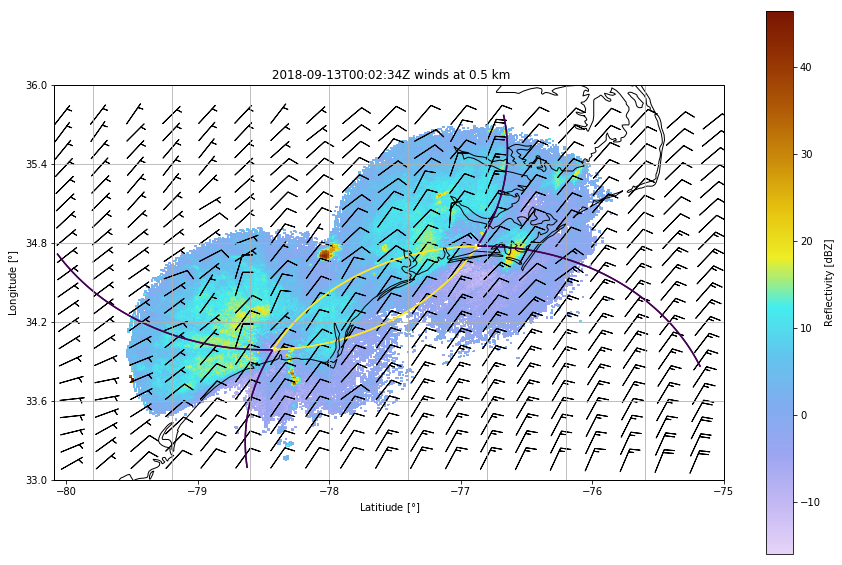

In [28]:
make_retrieved_grid(mhx_times[0])

In [29]:
print(len(mhx_times))

880


In [133]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=36, project='rainfall', walltime='2:00:00', 
                       processes=9, memory='128GB')

cluster.scale(18)         # Ask for ten workers

from dask.distributed import Client
client = Client(cluster)  # Connect this local process to remote workers

# wait for jobs to arrive, depending on the queue, this may take some time

import dask.array as da
from distributed import wait

In [152]:
client

Client Scheduler: tcp://140.221.70.8:36076 Dashboard: http://140.221.70.8:34921/status,Cluster Workers: 18 Cores: 72 Memory: 255.96 GB


In [158]:
cluster.stop_all_jobs()

In [145]:
time_inds = np.where(np.logical_and(mhx_times >= datetime.datetime(2018, 9, 14, 8, 0, 1), 
                                    mhx_times <= datetime.datetime(2018, 9, 14, 10, 0, 1)))[0]
make_grid = lambda x: make_retrieved_grid(x, ltx_list, mhx_list, True)
make_grid_no_hrrr = lambda x: make_retrieved_grid(x, ltx_list, mhx_list, False)
futures = client.map(make_grid, ltx_times[229:426])
wait(futures)

DoneAndNotDoneFutures(done={<Future: status: error, key: <lambda>-9a28188099ad668f85baf6b0fea28ab9>, <Future: status: error, key: <lambda>-da50bca0a7a5a8963d8361f101825b63>, <Future: status: error, key: <lambda>-cde97065df6af09542fe8ef61e7fe3f9>, <Future: status: error, key: <lambda>-16530ef4dabf75b526fe8b883e9b10ac>, <Future: status: error, key: <lambda>-cad06eb91d6008ea1ac432589c0be55d>, <Future: status: error, key: <lambda>-1c3393417b54d7cf11bac1a0c7e1d4a7>, <Future: status: error, key: <lambda>-5b5ae982c5e75c2dcecebcf0071c4e71>, <Future: status: error, key: <lambda>-ac5c86a5b1fc4b39ba87a1cacf6da441>, <Future: status: error, key: <lambda>-a846b5731d7f0d7a4ef91d1d2fded86b>, <Future: status: error, key: <lambda>-988487c9ece043ba22dd33a1f4c098c3>, <Future: status: error, key: <lambda>-219b3224af3aebbc8bd09e1fc76efaad>, <Future: status: error, key: <lambda>-abe3cc081b10029353d46eea17fe8bc3>, <Future: status: error, key: <lambda>-808a642a70f05c240ac90b3df441839c>, <Future: status: error,

## Loading data...
## Dealiasing...
## Gridding...
## Processing HRRR data...
## Running PyDDA...
Calculating weights for radars 0 and 1
Calculating weights for models...
Starting solver 
rmsVR = 458.4524133104527
Total points:1857994.0
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Max w  
|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000| 128.7312|   0.0000
Norm of gradient: 0.0009519768855869965
Iterations before filter: 10
Applying low pass filter to wind field...
Iterations after filter: 1
Iterations after filter: 2
Done! Time = 75.9
## Making plot..
## Saving plot...


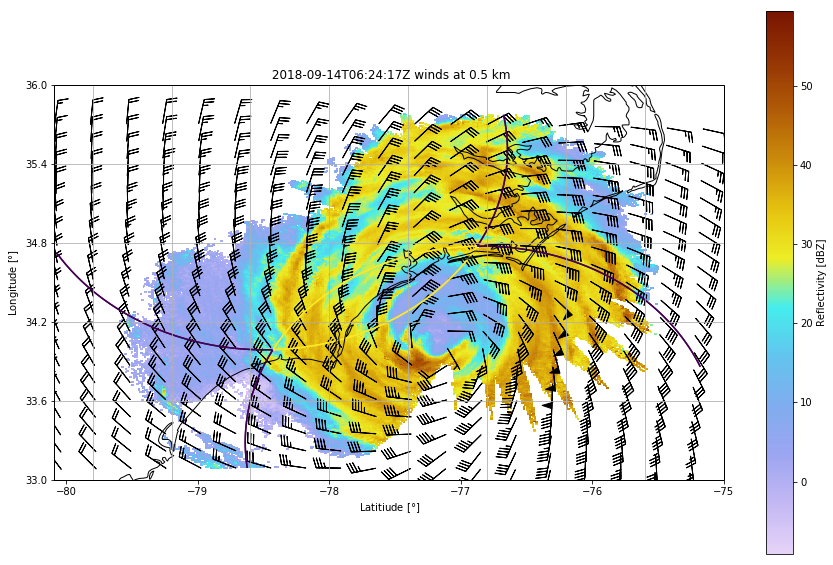

In [166]:
make_grid = lambda x: make_retrieved_grid(x, ltx_list, mhx_list, True)
make_grid_no_hrrr = lambda x: make_retrieved_grid(x, ltx_list, mhx_list, False)
make_grid_hrrr_only = lambda x: make_retrieved_grid_only_hrrr(x, ltx_list, mhx_list, True)
make_grid_hrrr_only(ltx_times[230])

In [ ]:
from scipy.signal import correlate2d
grid_all_ltx = pyart.io.read_grid('/lcrc/group/earthscience/rjackson/florence_winds/grids/20180914/05kmwinds_gridltx20180914.0624.nc')
grid_all_mtx = pyart.io.read_grid('/lcrc/group/earthscience/rjackson/florence_winds/grids/20180914/05kmwinds_gridmhx20180914.0624.nc')
grid_only_hrrr  = pyart.io.read_grid('/lcrc/group/earthscience/rjackson/florence_winds/grids/20180914/05kmwinds_gridltx20180914.0624.onlyhrrr.nc')

correlation_u = correlate2d(grid_all.fields["u"]["data"][1], grid_only_hrrr.fields["u"]["data"][1])
correlation_v = correlate2d(grid_all.fields["v"]["data"][1], grid_only_hrrr.fields["v"]["data"][1])

plt.pcolormesh(correlation_u)
plt.colorbar()